# Лабораторная работа №5

Провести моделирование уравнения параболического типа.

## Вариант №14 — задача 3.14

**Условие.**  
В прямоугольной области, периодически замкнутой по оси $x$, расположен потенциальный барьер с щелью  
$$
U(x) = U_0 \, \eta(|x| - \varepsilon),
$$
где $\eta(x)$ — функция Хевисайда. Таким образом, при $|x| < \varepsilon$ потенциал равен нулю (щель), а при $|x| \ge \varepsilon$ равен $U_0$ (барьер).

Требуется смоделировать прохождение **плоского волнового пакета** (см. формулу (П.3.3)) через щель. Волновой пакет движется вдоль оси $y$.

---

## 1. Математическая модель

Рассматриваем двумерное уравнение Шрёдингера в безразмерном виде
$$
i \frac{\partial \psi}{\partial t}
= -\frac12 \Delta \psi + U(x)\,\psi, 
\quad (x,y)\in \Omega,
$$
где $\Omega = [-L_x/2, L_x/2] \times [-L_y/2, L_y/2]$.

Потенциал:
$$
U(x) = U_0\,\eta(|x| - \varepsilon) =
\begin{cases}
0, & |x| < \varepsilon,[4pt]
U_0, & |x|\ge \varepsilon.
\end{cases}
$$

Граничные условия:  
* по оси $x$ — **периодические** (по условию задачи),  
* по оси $y$ для простоты также зададим периодические условия, чтобы избежать отражений от границ:
$$
\psi(x+L_x, y, t) = \psi(x, y, t),\quad
\psi(x, y+L_y, t) = \psi(x, y, t).
$$

Так область становится «тором», а барьер с щелью по $x$ периодически повторяется.

---

## 2. Начальное условие — плоский волновой пакет

Используем формулу (П.3.3) для плоского волнового пакета, который движется вдоль оси $y$:

$$
\psi_0(r) = a\big((r - r_0, n); \varepsilon_p\big)\;e^{i(k, r)},
$$
где
- $r = (x, y)$,\quad $r_0 = (x_0, y_0)$ — центр пакета,
- $n = (0, 1)$ — направление распространения вдоль оси $y$,
- $(k, r) = k_0 y$ (берём $k = (0, k_0)$),
- $\varepsilon_p$ — «полуширина» пакета по направлению движения.

Амплитуда $a(s; \varepsilon_p)$ выбирается по П.3:
$$
a(s; \varepsilon_p) =
\eta(\varepsilon_p - |s|)\,
\cos^3\!\left(\frac{\pi s}{2\varepsilon_p}\right),
\quad s = (r - r_0, n) = y - y_0.
$$

---

## 3. Численная схема

Сеточный оператор Лапласиана в прямоугольной области с периодическими условиями по обеим осям:
$$
(\Delta_h \psi)_{i,j} \approx
\frac{\psi_{i-1,j} - 2\psi_{i,j} + \psi_{i+1,j}}{h_x^2}
+
\frac{\psi_{i,j-1} - 2\psi_{i,j} + \psi_{i,j+1}}{h_y^2}.
$$

Мы будем хранить оператор
$$
L \approx -\Delta_h,
$$
то есть
$$
(L\psi)_{i,j} =
\left(\frac{2}{h_x^2} + \frac{2}{h_y^2}\right)\psi_{i,j}
- \frac{1}{h_x^2}(\psi_{i-1,j} + \psi_{i+1,j})
- \frac{1}{h_y^2}(\psi_{i,j-1} + \psi_{i,j+1}).
$$

Тогда гамильтониан:
$$
H \psi = -\frac12 \Delta_h \psi + U\psi
= \frac12 L\psi + U\psi.
$$

Для эволюции по времени используем неявную схему Кранка–Николсон для уравнения
$$
i \psi_t = H\psi:
$$
$$
\big(I + i \tfrac{\tau}{2} H\big)\psi^{n+1}
=
\big(I - i \tfrac{\tau}{2} H\big)\psi^{n},
$$
то есть
$$
A \psi^{n+1} = B \psi^n,
$$
где
$$
A = I + i\tfrac{\tau}{2} H,\quad
B = I - i\tfrac{\tau}{2} H.
$$

На каждом шаге времени решаем СЛАУ
$$
A \psi^{n+1} = B \psi^n
$$
методом `spsolve` из `scipy.sparse.linalg`.

Визуализировать будем плотность вероятности
$$
\rho(x,y,t) = |\psi(x,y,t)|^2,
$$
и расположение потенциального барьера со щелью.


In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import sparse as sp
from scipy.sparse import linalg as LA
from IPython.display import clear_output

%matplotlib inline


In [2]:
# Размеры области
Lx = 10.0   # длина по x
Ly = 10.0   # длина по y

# Число узлов сетки
n_x = 128   # можно уменьшить до 64, если будет тормозить
n_y = 128

# Шаги сетки
h_x = Lx / n_x
h_y = Ly / n_y

# Временной шаг и число шагов
tau = 0.001   # шаг по времени
t_end = 1.0   # конечное время моделирования
n_steps = int(t_end / tau)

print(f"hx = {h_x:.3f}, hy = {h_y:.3f}, n_steps = {n_steps}")

# Сетка по x и y (центр ячеек)
x = np.linspace(-Lx/2 + h_x/2, Lx/2 - h_x/2, n_x)
y = np.linspace(-Ly/2 + h_y/2, Ly/2 - h_y/2, n_y)
X, Y = np.meshgrid(x, y, indexing='ij')


hx = 0.078, hy = 0.078, n_steps = 1000


In [ ]:
def getL_periodic_xy(n_x, n_y, h_x, h_y):
    """
    Строит разреженную матрицу L ~ -Δ_h
    с периодическими граничными условиями по x и y.
    Размер матрицы: (n_x * n_y) x (n_x * n_y)
    """
    # Нумерация ячеек
    k = np.arange(n_x * n_y, dtype=int).reshape((n_x, n_y))

    # Все пары индексов (i, j)
    I, J = np.meshgrid(np.arange(n_x), np.arange(n_y), indexing='ij')
    I = I.flatten()
    J = J.flatten()

    iC = k[I, J]                         # центр
    iL = k[(I - 1) % n_x, J]             # слева
    iR = k[(I + 1) % n_x, J]             # справа
    iB = k[I, np.clip(J - 1, 0, n_y - 1)]# снизу
    iT = k[I, np.clip(J + 1, 0, n_y - 1)]# сверху

    # Заполняем матрицу
    row = np.concatenate([iC, iC, iC, iC, iC])
    col = np.concatenate([iC, iL, iR, iB, iT])
    val = np.concatenate([
        np.full(iC.size,  2.0 / h_x**2 + 2.0 / h_y**2),   # диагональ
        np.full(iL.size, -1.0 / h_x**2),                  # соседи по x
        np.full(iR.size, -1.0 / h_x**2),
        np.full(iB.size, -1.0 / h_y**2),                  # соседи по y
        np.full(iT.size, -1.0 / h_y**2),
    ])

    L = sp.csr_matrix((val, (row, col)), shape=(n_x * n_y, n_x * n_y))
    return L

L = getL_periodic_xy(n_x, n_y, h_x, h_y)
L


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 81920 stored elements and shape (16384, 16384)>

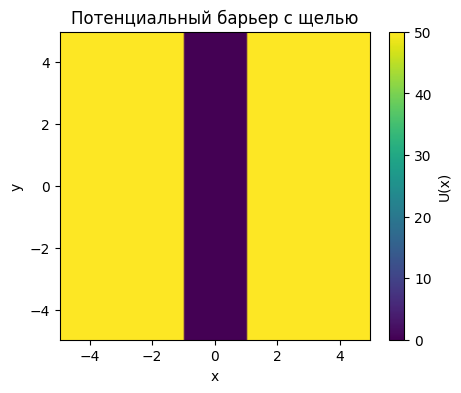

In [4]:
# Параметры барьера
U0 = 50.0     # высота барьера
eps = 1.0     # полу-ширина щели по x: |x| < eps — щель

# Потенциал U(x): U = 0 в щели, U = U0 вне щели
U = np.zeros_like(X)
U[np.abs(X) >= eps] = U0

# Визуализируем потенциал
plt.figure(figsize=(5, 4))
plt.imshow(U.T, extent=[x.min(), x.max(), y.min(), y.max()],
           origin='lower', aspect='auto')
plt.colorbar(label='U(x)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Потенциальный барьер с щелью')
plt.show()


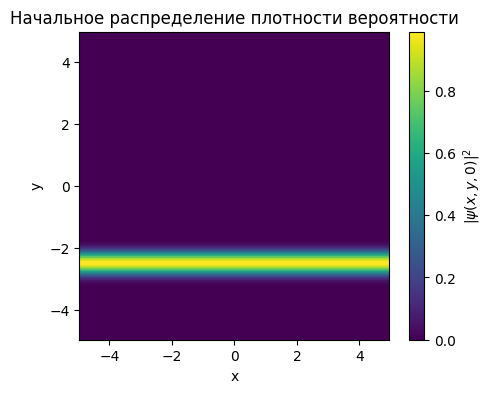

In [7]:
def amplitude_flat_packet(s, eps_p):
    """
    Амплитуда a(s; eps_p) = eta(eps_p - |s|) * cos^3(pi s / (2 eps_p)).
    s может быть numpy-массивом.
    """
    a = np.zeros_like(s, dtype=float)
    mask = np.abs(s) < eps_p
    a[mask] = np.cos(np.pi * s[mask] / (2 * eps_p))**3
    return a

# Параметры пакета
eps_p = 1.0      # полу-ширина пакета вдоль направления движения
k0 = 5.0         # модуль волнового числа (по y)
x0 = 0.0         # центр пакета по x
y0 = -Ly / 4.0   # центр пакета по y (ниже центра области)

# Направление распространения вдоль оси y
n_vec = np.array([0.0, 1.0])

# s = (r - r0, n) = (X - x0)*n_x + (Y - y0)*n_y
s = (X - x0) * n_vec[0] + (Y - y0) * n_vec[1]

# Амплитуда
a0 = amplitude_flat_packet(s, eps_p)

# Плоская волна e^{i(k, r)} с k = (0, k0)
phase = np.exp(1j * (0.0 * X + k0 * Y))

# Начальное условие
psi0 = a0 * phase

# Визуализируем начальную плотность вероятности
plt.figure(figsize=(5, 4))
plt.imshow((np.abs(psi0)**2).T,
           extent=[x.min(), x.max(), y.min(), y.max()],
           origin='lower', aspect='auto')
plt.colorbar(label=r'$|\psi(x,y,0)|^2$')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Начальное распределение плотности вероятности')
plt.show()


In [28]:
# Преобразуем всё к векторному виду
N = n_x * n_y

# Оператор гамильтониана: H = 0.5 * L + diag(U)
H = 0.5 * L + sp.diags(U.ravel(), format='csr')

# Матрицы схемы Кранка–Николсон:
# (I + i tau/2 H) psi^{n+1} = (I - i tau/2 H) psi^{n}
I = sp.eye(N, format='csr')

A = I + 1j * tau / 2.0 * H
B = I - 1j * tau / 2.0 * H

# Начальное условие в виде вектора
psi = psi0.ravel().astype(complex)

# Функция для вычисления полной нормы (должна сохраняться)
def probability_norm(psi_vec):
    return np.sum(np.abs(psi_vec)**2) * h_x * h_y
# нормируем
norm0 = probability_norm(psi)
psi /= np.sqrt(norm0)

print("Начальная норма вероятности:", probability_norm(psi))


Начальная норма вероятности: 1.0


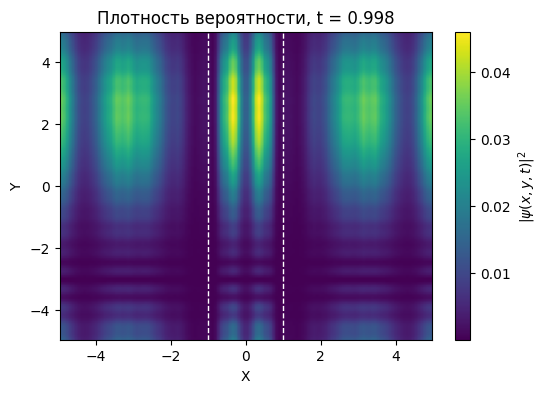

Шаг: 998 норма вероятности: 0.9999999999999718


In [29]:
# Настройки визуализации
drawing_pause = 2   # как часто рисовать (каждые drawing_pause шагов)
vmin, vmax = 0.0, None  # можно зафиксировать vmax, если хочется
solver = LA.factorized(A)
for n in range(n_steps):
    # Правая часть: B psi^n
    rhs = B @ psi

    # Решаем A psi^{n+1} = rhs
    psi = solver(rhs)

    # (необязательно) нормировка для компенсации численных ошибок
    # psi = psi / np.sqrt(probability_norm(psi))

    if n % drawing_pause == 0:
        clear_output(wait=True)

        psi_grid = psi.reshape((n_x, n_y))
        density = np.abs(psi_grid)**2

        plt.figure(figsize=(6, 4))
        plt.imshow(density.T,
                   extent=[x.min(), x.max(), y.min(), y.max()],
                   origin='lower', aspect='auto')
        plt.colorbar(label=r'$|\psi(x,y,t)|^2$')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title(f'Плотность вероятности, t = {n * tau:.3f}')

        # Нарисуем положение барьера (примерно)
        # Щель: |x| < eps, барьер: |x| >= eps
        plt.axvline(-eps, color='white', linestyle='--', linewidth=1)
        plt.axvline(+eps, color='white', linestyle='--', linewidth=1)

        plt.show()

        print("Шаг:", n, "норма вероятности:", probability_norm(psi))
